In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv("LSTM-Multivariate_pollution.csv")
df_train.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [3]:
df_train.shape

(43800, 9)

In [4]:
df_train['wnd_dir'].value_counts()

wnd_dir
SE    15290
NW    14130
cv     9384
NE     4996
Name: count, dtype: int64

In [5]:
df_test = pd.read_csv("pollution_test_data1.csv")
df_test.head()

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93


In [6]:
newcols_train=pd.get_dummies(df_train['wnd_dir'],).astype(int)
newcols_test=pd.get_dummies(df_test['wnd_dir'],).astype(int)
encoded_train=pd.concat([df_train.drop('wnd_dir',axis=1),newcols_train],axis=1)
encoded_test=pd.concat([df_test.drop('wnd_dir',axis=1),newcols_test],axis=1)
encoded_train

,date,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,246.72,0,0,0,1,0,0


In [7]:
dates=pd.to_datetime(encoded_train['date'])
df_indexed = encoded_train.drop('date',axis=1)
df_indexed.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
0,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
1,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
3,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
4,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


In [8]:
encoded_test = encoded_test[df_indexed.columns]
encoded_test.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
0,128,-16,4,1027,3.58,0,0,0,0,1,0
1,77,-17,5,1027,7.60,0,0,0,0,1,0
2,65,-16,4,1027,9.39,0,0,0,0,1,0
3,79,-16,1,1028,0.89,0,0,0,0,0,1
4,93,-14,0,1028,1.79,0,0,1,0,0,0


In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_train = scaler.fit_transform(df_indexed)
scaled_data_test = scaler.transform(encoded_test)
scaled_df_train = pd.DataFrame(scaled_data_train, columns=df_indexed.columns)
scaled_df_test = pd.DataFrame(scaled_data_test, columns=encoded_test.columns)
scaled_df_train.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
0,0.129779,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.0,0.0,1.0,0.0
1,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0,0.0,1.0,0.0
2,0.159960,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.0,0.0,1.0,0.0
3,0.182093,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.0,0.0,1.0,0.0
4,0.138833,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.0,0.0,1.0,0.0


In [10]:
n_steps_in = 31
n_steps_out = 1 
batch_size = 32 
target_column = 'pollution'

In [11]:
X_train_data = scaled_df_train.drop(columns=[target_column]).values
y_train_data = scaled_df_train[[target_column]].values

X_test_data = scaled_df_test.drop(columns=[target_column]).values
y_test_data = scaled_df_test[[target_column]].values

print(f"X_train_data shape: {X_train_data.shape}")
print(f"y_train_data shape: {y_train_data.shape}")
print(f"X_test_data shape: {X_test_data.shape}")
print(f"y_test_data shape: {y_test_data.shape}")

X_train_data shape: (43800, 10)
y_train_data shape: (43800, 1)
X_test_data shape: (346, 10)
y_test_data shape: (346, 1)


In [12]:
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    data=X_train_data,
    targets=y_train_data,
    length=n_steps_in,
    batch_size=batch_size,
    stride=1
)

test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    data=X_test_data,
    targets=y_test_data,
    length=n_steps_in,
    batch_size=batch_size,
    stride=1
)

print(f"\nNumber of batches in training generator: {len(train_generator)}")
print(f"Number of batches in test generator: {len(test_generator)}")


Number of batches in training generator: 1368
Number of batches in test generator: 10


In [13]:
model = Sequential([
    LSTM(units=32, activation='relu', return_sequences=True, input_shape=(n_steps_in, X_train_data.shape[1])),
    Dropout(0.3), 
    LSTM(units=64, activation='relu', return_sequences=True),
    Dropout(0.4),
    LSTM(units=32, activation='relu', return_sequences=False),
    Dropout(0.3),
    Dense(units=n_steps_out) 
])


model.compile(optimizer='adam', loss='mse')

model.summary()

C:\Users\HP\anaconda3\envs\testingopenai\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 31, 32)              │           5,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 31, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 31, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,785 (167.13 KB)

 Trainable params: 42,785 (167.13 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [17]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=1
)

Epoch 1/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - loss: 0.0053 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 2/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - loss: 0.0056 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 3/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - loss: 0.0056 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 4/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - loss: 0.0048 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 5/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 0.0049 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 6/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 0.0050 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 7/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - loss: 0.0049 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 8/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 0.0046 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 9/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - loss: 0.0050 - val_loss: 0.004

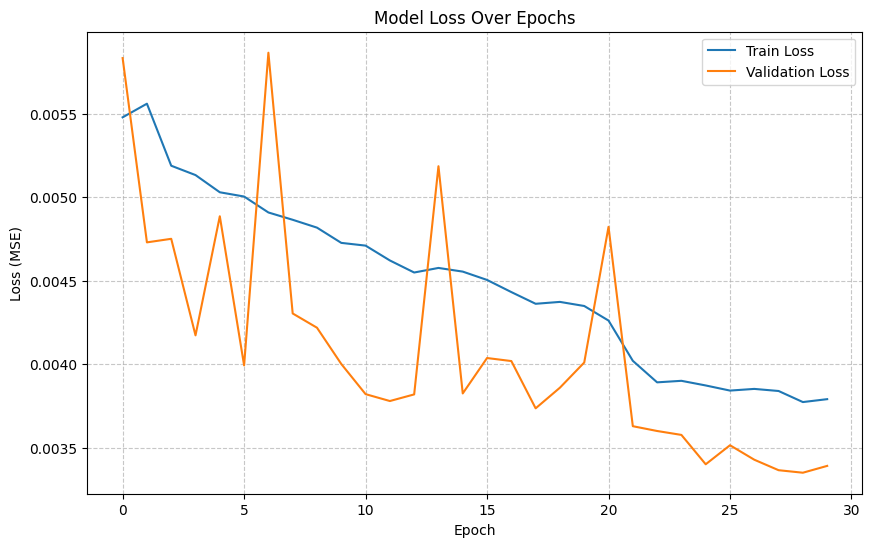

In [18]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[reduce_lr],
    verbose=1
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

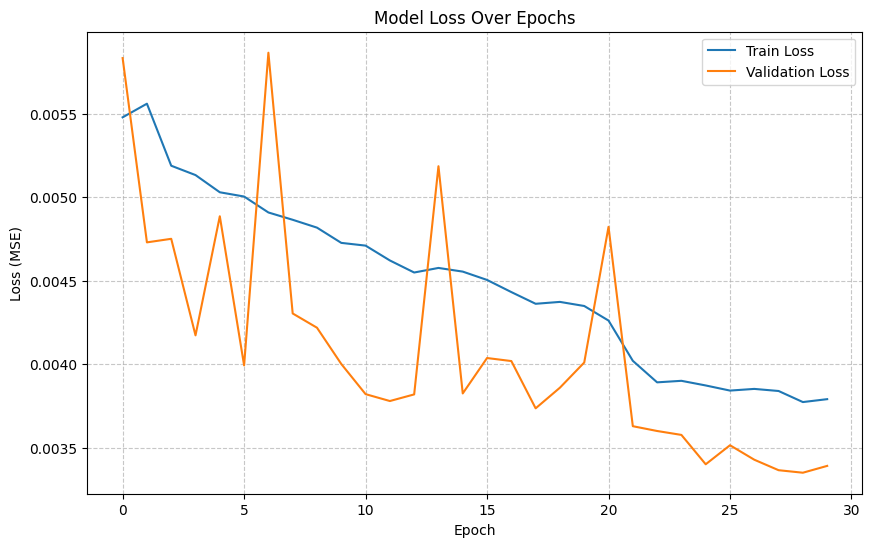

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


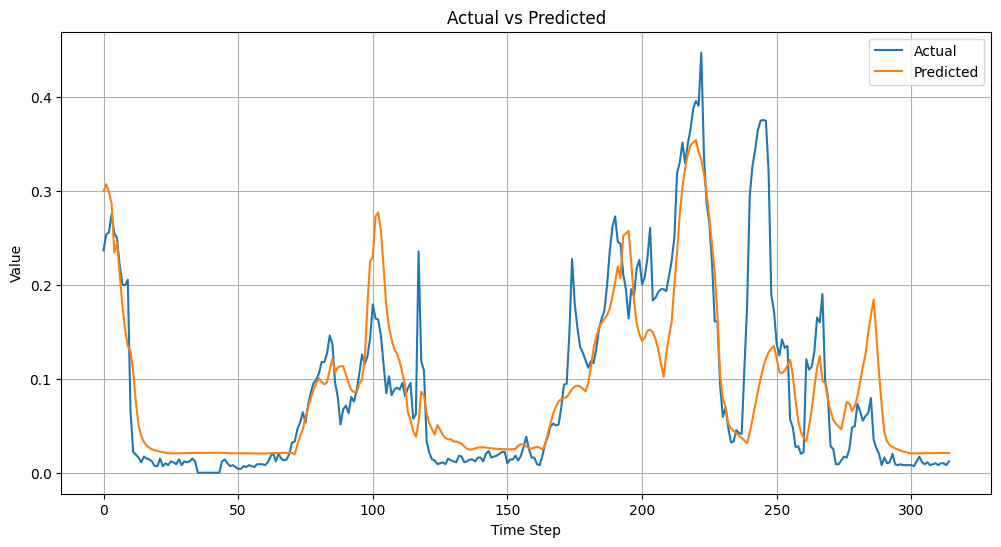

In [20]:
test_predictions = model.predict(test_generator)

y_test_true = []
for i in range(len(test_generator)):
    _, y = test_generator[i]
    y_test_true.extend(y)


y_test_true = np.array(y_test_true).flatten()
y_test_pred = test_predictions.flatten()


results_df = pd.DataFrame({'Actual': y_test_true, 'Predicted': y_test_pred})


plt.figure(figsize=(12, 6))
plt.plot(y_test_true, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
